In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import settings
import utils

logger = utils.init_logger(f'overall_survival', './outputs')
logger.info("Jupyter notebook start")

DATA_RESULTS = os.path.join(settings.DATA_PATH, "Results")
logger.info(f"Data results: {DATA_RESULTS}")

clinical_info = pd.read_csv(settings.DATA_PATH_CLINICAL_PROCESSED, index_col=0)

(root): Jupyter notebook start


(root): Data results: /Users/jmigual/Documents/Projects/CNNSurv/Data/Results


(matplotlib.backends): backend module://ipykernel.pylab.backend_inline version unknown


In [2]:

results = {
    'scalar': utils.all_results(DATA_RESULTS + "/Model_scalar_LOOCV_3", "mixed", elem_folds=True)[2],
    'volume': utils.all_results(DATA_RESULTS + "/Model_volume_LOOCV_3", "mixed", elem_folds=True)[2],
}

(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_3 mixed


(utils.results): Found 490


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_scalar_fix_3 mixed



(utils.results): Searching on /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_3 mixed


(utils.results): Found 490


(utils.results): Finished /Users/jmigual/Documents/Projects/CNNSurv/Data/Results/Model_volume_fix_3 mixed



Index(['id', 'age', 'sex', 'event', 'time'], dtype='object')


(root): 0.38202247191011235


298 192 0


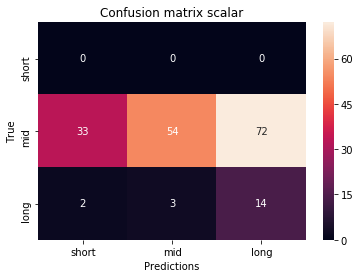

In [12]:
print(clinical_info.columns)

LONG_THRESHOLD = 4
MID_THRESHOLD = 0

long_survivors = set(clinical_info[clinical_info['time'] > LONG_THRESHOLD]['id'])
short_survivors = set(clinical_info[clinical_info['time'] < MID_THRESHOLD]['id'])
mid_survivors = set(clinical_info['id']) - long_survivors - short_survivors

sets = [("long", long_survivors), ("short", short_survivors), ("mid", mid_survivors)]


def test_positive(survs: set, df: pd.DataFrame, str_key: str):
    # print(key)
    # print(df[df['pA'].isin(survs)])
    comps = df[df['pA'].isin(survs) & (df['pB'] == str_key)]
    total = len(comps)
    count = len(comps[comps['predictions']])
    # print(total)
    # print(count)
    # print(comps[comps['predictions']])
    
    comps = df[(df['pA'] == str_key) & (df['pB'].isin(survs))]
    total += len(comps)
    count += len(comps[~comps['predictions']])
    
    return count/total


def get_individual_prediction(pred_df, key):
    if test_positive(long_survivors, pred_df, key) > 0.5:
            return "long"
    elif test_positive(mid_survivors, pred_df, key) > 0.5:
        return "mid"
    else:
        return "short"
    

def get_individual_prediction_2(pred_df: pd.DataFrame, key: str):
    
    # ['age_a', 'age_b', 'time_a', 'time_b', 'pA', 'pB', 'labels',
    #  'predictions', 'probabilities', 'gather_a', 'gather_b'])
    time = None
    
    pred_times = []
    for i in range(2):
        pred_df = pred_df.sample(frac=1)
#         logger.debug(f"Iter {i}")
        for _, row in pred_df.iterrows():
            if key == row['pA']:
                pair_time = row['time_b']
                comp = not bool(row['predictions'])
                label = not bool(row['labels'])
            else:
                pair_time = row['time_a']
                comp = bool(row['predictions'])
                label = bool(row['labels'])
            
            if time is None:
                time = pair_time
                diff = 0
            
            # comp == True means time_b > time_a
            
            alpha = .10
            if (comp and time < pair_time) or not comp and time > pair_time:
                diff = alpha*(pair_time - time) + (1 - alpha)*diff
                time += diff
            else:
                diff *= 1 - alpha
                
#             logger.debug(f"{time:.3} {pair_time:.3} {diff:.2} | {comp} {label}")
                
            if i > 0:
                pred_times.append(time)
        
    pred_times = np.array(pred_times)
    real_time = clinical_info.loc[clinical_info['id'] == key, 'time'].iloc[0]
    # print(real_time)
    
    pred_mean = pred_times.mean()
    c_index = sum(pred_df['predictions'] == pred_df['labels'])/len(pred_df)
#     print(c_index)
    logger.debug(f"{key} {pred_mean:.3} vs {real_time:.3} | CI {c_index:.3}")
#     plt.hist(pred_times, range=(0, 11))
#     plt.axvline(pred_times.mean(), color='r')
#     plt.axvline(real_time, color='g')
#     plt.show()
    
    if pred_mean > LONG_THRESHOLD:
        return "long"
    elif pred_mean >= MID_THRESHOLD:
        return "mid"
    else:
        return "short"


def get_risk_predictions(preds):
    y_true = []
    y_pred = []
    for key, pred_df in preds.items():
        # print(key)
        # print(pred_df.columns)
        # 
        # if key != "FHBO042":
        #     continue
        
        is_censored = not bool(clinical_info.loc[clinical_info['id'] == key, 'event'].iloc[0])
        if is_censored:
            continue
        
        for name, class_set in sets:
            if key in class_set:
                y_true.append(name)
                break
        else:
            print("Error no set found")
        
        # Test long survivability
        # y_pred.append(get_individual_prediction_2(pred_df, key))
        y_pred.append(get_individual_prediction(pred_df, key))
#         break
    return y_true, y_pred


def plot_risk_predictions(preds, name: str):
    y_true, y_pred = get_risk_predictions(preds)
    labels = ['short', 'mid', 'long']
    matrix: np.ndarray = confusion_matrix(y_true, y_pred, labels=labels)
    logger.info(matrix.diagonal().sum()/matrix.sum())
    
    print(len(long_survivors), len(mid_survivors), len(short_survivors))

    sns.heatmap(matrix, vmin=0, annot=True, xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion matrix {name}")
    plt.savefig(f"outputs/survival_{name}.png", dpi=300)
    plt.ylabel("True")
    plt.xlabel("Predictions")
    plt.show()
    
    
plot_risk_predictions(results['scalar'], 'scalar')
# plot_risk_predictions(results['volume'], 'volume')